In [1]:
from src.plite import PlanckLitePy
import camb
import numpy as np 
import os 
import math
import pickle 
import numpy as np
import matplotlib.pylab as plt 
from getdist import plots, MCSamples
import pandas as pd
import scipy.stats as ss 
import emcee
from src.torchemu.gaussianprocess import GaussianProcess
from config import get_config
import torch

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 15

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3}
contours = [0.68,0.95]
linewidth = 2 

In [268]:
NLHS = 2000
NDIM = 6
NTEST = 1000
NSTD = 8
USE_GP = True
UNIFORM_PRIOR = False
NCOV = 2.0

# Reference

<img src="images/priors.png" width=1000 />

<img src="images/planck_2018.png" width=1000 />

<img src="images/from_paper.png" width=1000 />

# Planck Lite

In [3]:
TT2018=PlanckLitePy(data_directory='data', year=2018, spectra='TT', use_low_ell_bins=False)

In [4]:
ls, Dltt, Dlte, Dlee = np.genfromtxt('data/Dl_planck2015fit.dat', unpack=True)
ellmin=int(ls[0])

In [5]:
expected=-101.58123068722583
loglike=TT2018.loglike(Dltt, Dlte, Dlee, ellmin)
print('Planck-lite-py log likelihood:', loglike)
print('Expected log likelihood:', expected)
print('Difference:', loglike-expected, '\n\n')

Planck-lite-py log likelihood: -101.58123068722583
Expected log likelihood: -101.58123068722583
Difference: 0.0 




In [6]:
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=True)

# call the likelihood function
loglike=TTTEEE2018_lowTTbins.loglike(Dltt, Dlte, Dlee, ellmin) #ellmin = 2 by default
expected=-293.95586501795134
print('Planck-lite-py likelihood:', loglike)
print('Expected log likelihood:', expected)
print('Difference:', loglike-expected, '\n\n')

Planck-lite-py likelihood: -293.95586501795134
Expected log likelihood: -293.95586501795134
Difference: 0.0 




# CAMB

Use CAMB rather than CLASS to build the emulator.

In [7]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
pars.set_cosmology(ombh2=0.0223828, omch2=0.1201075, mnu=0.06, omk=0, tau=0.054, thetastar=1.0446/100)
# pars.set_cosmology(H0=67.32117, ombh2=0.0223828, omch2=0.1201075, mnu=0.06, omk=0, tau=0.054)
pars.InitPower.set_params(As=2.100549e-9, ns=0.9660499)
pars.set_for_lmax(2508, lens_potential_accuracy=0)
results = camb.get_results(pars)
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

In [8]:
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
camb_tt = powers['unlensed_scalar'][:,0]
camb_ee = powers['unlensed_scalar'][:,1]
camb_bb = powers['unlensed_scalar'][:,2]
camb_te = powers['unlensed_scalar'][:,3]

ls = np.arange(camb_tt.shape[0])

condition_1 = (ls >= 2) & (ls <= 2508)

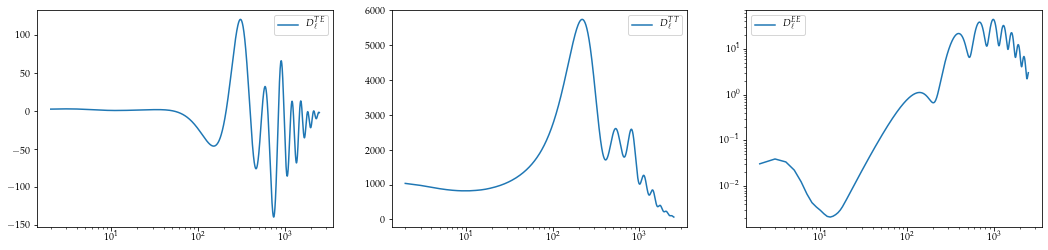

In [9]:
plt.figure(figsize = (18,4))
plt.subplot(131)
plt.plot(ls[condition_1], camb_te[condition_1], label = r'$D_{\ell}^{TE}$')
plt.xscale('log')
plt.legend()
plt.subplot(132)
plt.plot(ls[condition_1], camb_tt[condition_1], label = r'$D_{\ell}^{TT}$')
plt.xscale('log')
plt.legend()
plt.subplot(133)
plt.loglog(ls[condition_1], camb_ee[condition_1], label = r'$D_{\ell}^{EE}$')
plt.legend()
plt.show()

In [10]:
TT2018.loglike(camb_tt[condition_1], camb_te[condition_1], camb_ee[condition_1], ellmin)

-372.2261813735533

Other tests

In [11]:
TTTEEE2018_lowTTbins=PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=True)

In [12]:
# call the likelihood function
loglike=TTTEEE2018_lowTTbins.loglike(Dltt, Dlte, Dlee, ellmin) 

In [13]:
loglike

-293.95586501795134

In [14]:
TTTEEE2018_lowTTbins.loglike(camb_tt[condition_1], camb_te[condition_1], camb_ee[condition_1], ellmin) 

-692.2446397950042

# Public Planck 2018 Results

In [15]:
folder = '/home/harry/Desktop/Planck/base/plikHM_TTTEEE_lowl_lowE/'

c1 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_1.txt')
c2 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_2.txt')
c3 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_3.txt')
c4 = np.loadtxt(folder + 'base_plikHM_TTTEEE_lowl_lowE_4.txt')
# 0 omegabh2	\Omega_b h^2
# 1 omegach2	\Omega_c h^2
# 2 theta	100\theta_{MC}
# 3 tau	\tau
# 4 logA	{\rm{ln}}(10^{10} A_s)
# 5 ns	n_s
# 28 H0*	H_0

In [17]:
# indices = [0, 1, 2, 3, 4, 5]
# cosmoparams_1 = c1[:,2:][:,indices]
# cosmoparams_2 = c2[:,2:][:,indices]
# cosmoparams_3 = c3[:,2:][:,indices]
# cosmoparams_4 = c4[:,2:][:,indices]

# cosmoparams = np.concatenate([cosmoparams_1, cosmoparams_2, cosmoparams_3, cosmoparams_4], axis = 0)

# mean = np.mean(cosmoparams, axis = 0)
# std = np.std(cosmoparams, axis = 0)
# cov = np.cov(cosmoparams.T)

# Samples from CAMB Run

In [145]:
camb_samples_1 = np.loadtxt('samples/camb_samples_1.txt')
camb_samples_2 = np.loadtxt('samples/camb_samples_2.txt')

In [147]:
np.mean(camb_samples_1, axis = 0)

array([0.022, 0.122, 1.041, 0.047, 3.027, 0.955])

In [148]:
np.mean(camb_samples_2, axis = 0)

array([0.022, 0.122, 1.041, 0.047, 3.027, 0.955])

In [151]:
np.std(camb_samples_1, axis = 0) * 1000

array([0.103, 1.040, 0.218, 11.043, 22.321, 3.018])

In [152]:
np.std(camb_samples_2, axis = 0) * 1000

array([0.102, 1.051, 0.220, 11.112, 22.331, 3.026])

In [155]:
camb_samples_comb = np.vstack([camb_samples_1, camb_samples_2])

In [262]:
np.max(camb_samples_comb, axis = 0)

array([0.022, 0.127, 1.042, 0.106, 3.141, 0.970])

In [215]:
mean = np.mean(camb_samples_comb, axis = 0)

In [267]:
mean

array([0.022, 0.122, 1.041, 0.047, 3.027, 0.955])

In [159]:
np.std(camb_samples_comb, axis = 0) * 1000

array([0.103, 1.046, 0.219, 11.078, 22.327, 3.022])

In [265]:
cov = np.cov(camb_samples_comb.T)

In [266]:
cov * 1E8

array([[1.055, -6.475, 0.714, -7.161, -25.732, 12.121],
       [-6.475, 109.395, -8.132, 45.595, 353.407, -228.510],
       [0.714, -8.132, 4.795, -42.917, -101.820, 20.752],
       [-7.161, 45.595, -42.917, 12272.618, 24524.043, 386.078],
       [-25.732, 353.407, -101.820, 24524.043, 49851.000, 129.898],
       [12.121, -228.510, 20.752, 386.078, 129.898, 913.289]])

In [269]:
def generate_priors_multivariate(mean, covariance):
    return ss.multivariate_normal(mean, NCOV * covariance)

def generate_priors_custom(cfg):
    distributions = {}
    for i, name in enumerate(cfg.cosmo.names):
        if name == 'ombh2':
            distributions[name] = ss.uniform(0.015, 0.030 - 0.015)

        if name == 'omch2':
            distributions[name] = ss.uniform(0.10, 0.15 - 0.10)

        if name == 'thetastar':
            distributions[name] = ss.uniform(1.02, 1.06 - 1.02)

        if name == 'ns':
            distributions[name] = ss.uniform(0.90, 1.05 - 0.90)

        if name == 'tau':
            distributions[name] = ss.uniform(0.01, 0.10 - 0.01)

        if name == 'As':
            distributions[name] = ss.uniform(2.95, 3.15 - 2.95)
        
    return distributions

def generate_priors_uniform(cfg, mean, std):
    priors = {}
    for i, name in enumerate(cfg.cosmo.names):
        priors[name] = ss.uniform(mean[i] - NSTD * std[i], 2.0 * NSTD * std[i])
    return priors               

In [270]:
cfg = get_config('planck-2018')

In [271]:
if UNIFORM_PRIOR:
    priors = generate_priors_uniform(cfg, mean, std)
    samples = np.column_stack([priors[name].rvs(10000) for name in cfg.cosmo.names])
else:
    priors = generate_priors_multivariate(mean, cov)
    samples = priors.rvs(10000)

In [272]:
labels = [r'$\Omega_{b}h^{2}$', r'$\Omega_{cdm}h^{2}$', r'$100\theta_{MC}$', r'$\tau$', r'$ln(10^{10})A_{s}$', r'$n_{s}$']#, r'$H_{0}$']
names = ["x%s"%i for i in range(NDIM)]

In [273]:


samples_1 = MCSamples(samples=camb_samples_comb,names = names, labels = labels, settings = settings, label = 'Planck 2018')
samples_2 = MCSamples(samples=samples,names = names, labels = labels, settings = settings, label = 'Training Points Region')

Removed no burn in
Removed no burn in


In [276]:
c1 = '#B5CA8D'
c3 = '#222E50'
alpha = 0.7
contours = np.array([0.68,0.95])

# G = plots.getSubplotPlotter(subplot_size=2)
# G.settings.solid_contour_palefactor = 0.8
# G.settings.alpha_filled_add = alpha
# G.settings.num_plot_contours = 2
# G.settings.lw_contour = 2
# G.settings.axes_fontsize = 20
# G.settings.lab_fontsize = 20
# G.settings.fontsize = 35 # important for padding in x-axis 
# G.settings.legend_fontsize = 15
# samples_1.updateSettings({'contours': [0.68, 0.95]})
# G.triangle_plot(samples_1, filled = [True], contour_colors=[c1], contour_lws=[2], contour_ls=['-'])
# # plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
# plt.show()

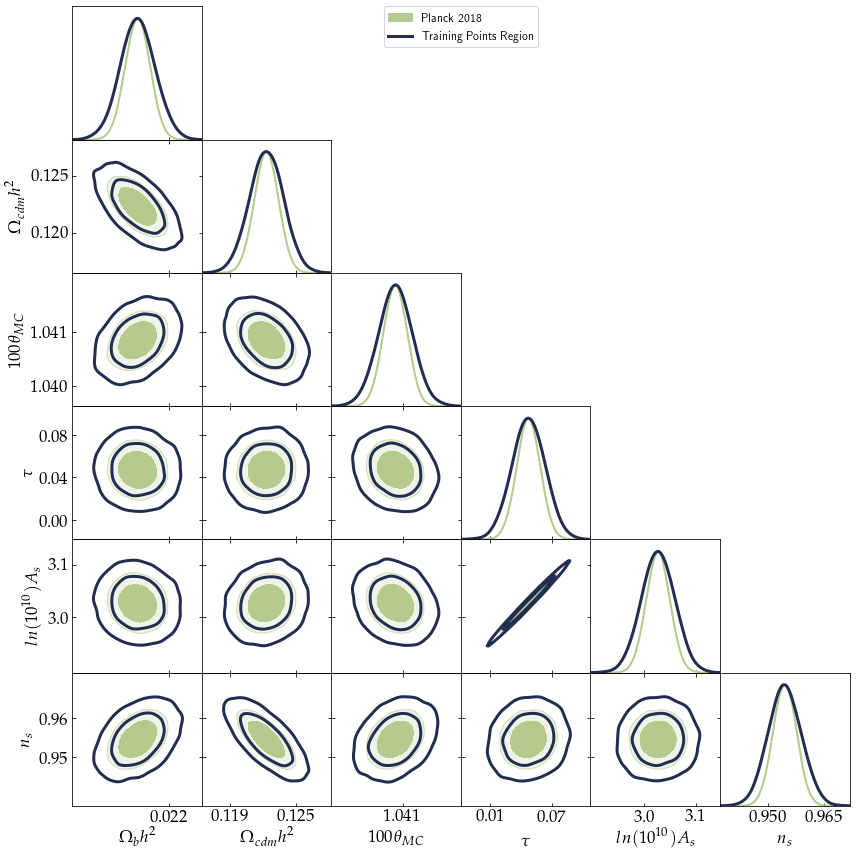

In [275]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_1, samples_2], filled = [True,False], contour_colors=[c1, c3], contour_lws=[2,3], contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

# Scale Training Points

In [225]:
def input_points_multivariate(cfg, priors):
    lhs_samples = pd.read_csv(f'lhs/samples_{NDIM}_{NLHS}.csv', index_col=0)
    dist = ss.norm(0, 1)
    scaled_samples = []
    for i in range(NDIM):
        scaled_samples.append(dist.ppf(lhs_samples.values[:,i]))
    scaled_samples = np.column_stack(scaled_samples)
    cholesky = np.linalg.cholesky(priors.cov)
    scaled = mean.reshape(NDIM, 1) + cholesky @ scaled_samples.T
    scaled = scaled.T
    return scaled

In [226]:
def input_points_uniform(cfg, priors):
    lhs_samples = pd.read_csv(f'lhs/samples_{NDIM}_{NLHS}.csv', index_col=0)
    scaled_samples = []
    for i, name in enumerate(cfg.cosmo.names):
        scaled_samples.append(priors[name].ppf(lhs_samples.values[:,i]))
    scaled_samples = np.column_stack(scaled_samples)
    return scaled_samples

In [227]:
def get_params(parameters: np.ndarray):

    params = {'ombh2': parameters[0],
             'omch2': parameters[1], 
              'thetastar': parameters[2]/100,
              'tau': parameters[3],
             'As': np.exp(parameters[4])*1E-10,
             'ns': parameters[5]}
             #'H0': parameters[4]}
    return params

In [228]:
def generate_cls(parameters: dict):

    pars = camb.CAMBparams()
    pars.set_cosmology(ombh2=parameters['ombh2'], omch2=parameters['omch2'], 
                       mnu=0.06, omk=0, tau=parameters['tau'], thetastar=parameters['thetastar'])
    pars.InitPower.set_params(As=parameters['As'], ns=parameters['ns'])
    pars.set_for_lmax(2508, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

    #Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
    #The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
    camb_tt = powers['unlensed_scalar'][:,0]
    camb_ee = powers['unlensed_scalar'][:,1]
    camb_bb = powers['unlensed_scalar'][:,2]
    camb_te = powers['unlensed_scalar'][:,3]

    ls = np.arange(camb_tt.shape[0])
    condition = (ls >= 2) & (ls <= 2508)
    
    powerspectra = {'ells': ls[condition], 'tt': camb_tt[condition], 
                    'te': camb_te[condition], 'ee': camb_ee[condition]}
    
    return powerspectra

In [229]:
def calculate_loglike(points):
    likelihood = PlanckLitePy(data_directory='data', year=2018, spectra='TTTEEE', use_low_ell_bins=False)
    # likelihood = PlanckLitePy(data_directory='data', year=2018, spectra='TT', use_low_ell_bins=False)
    npoints = points.shape[0]
    record_logl = np.zeros(npoints)
    for i in range(npoints):
        parameters = get_params(points[i])
        cls = generate_cls(parameters)
        record_logl[i] = likelihood.loglike(cls['tt'], cls['te'], cls['ee'], min(cls['ells'])) 
    return record_logl

In [230]:
if UNIFORM_PRIOR:
    cosmologies = input_points_uniform(cfg, priors) 
else:
    cosmologies = input_points_multivariate(cfg, priors)

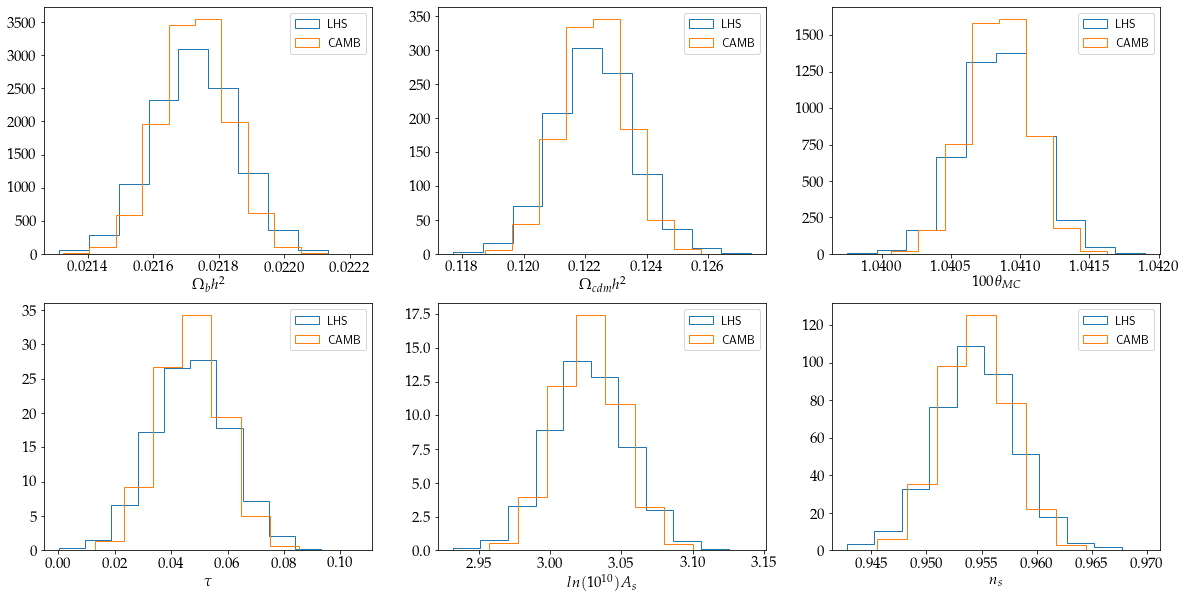

In [232]:
index = 0
plt.figure(figsize=(20,10))
for index in range(6):
    plt.subplot(2, 3, index+1)
    plt.hist(cosmologies[:,index], density = True, histtype = 'step', label = 'LHS')
    plt.hist(camb_samples_comb[:,index], density=True, histtype = 'step', label = 'CAMB')
    plt.xlabel(labels[index], fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':12})
plt.show()

Calculate the log-likelihood. The first $d$ columns are the cosmological parameters and the last column is the loglikelihood. 

In [37]:
%%time
cosmo_likelihood = calculate_loglike(cosmologies)

CPU times: user 3h 23min 25s, sys: 8min 25s, total: 3h 31min 51s
Wall time: 26min 44s


In [38]:
%%time
calculate_loglike(mean.reshape(1, -1))

CPU times: user 6.22 s, sys: 584 ms, total: 6.81 s
Wall time: 869 ms


array([-614.42447087])

In [39]:
class transform_loglike:
    
    def __init__(self, loglikelihood):
        self.loglikelihood = loglikelihood
        self.dist = ss.norm(0, 1)
        self.ytrain = self.forward()
        
    def forward(self):
        log_chi2 = np.log(-2*self.loglikelihood)
        # self.mean_log_chi2 = np.mean(log_chi2)
        # self.std_log_chi2 = np.std(log_chi2)
        # log_chi2_trans = (log_chi2 - self.mean_log_chi2) / self.std_log_chi2
        return log_chi2
    
    def inverse(self, prediction):
        # pred_trans = -np.exp(prediction * self.std_log_chi2 + self.mean_log_chi2)
        pred_trans = -0.5*np.exp(prediction)
        return pred_trans

In [40]:
testing = transform_loglike(cosmo_likelihood)

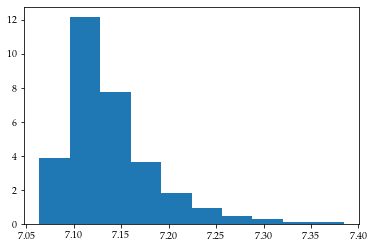

In [41]:
plt.hist(testing.ytrain, density = True)
plt.show()

In [42]:
class planckEmu:
    def __init__(self, cfg, inputs, loglike):
        self.cfg = cfg
        self.inputs = torch.from_numpy(inputs)
        self.ytrans = transform_loglike(loglike)
        self.outputs = torch.from_numpy(self.ytrans.ytrain)
        
        print('Training emulator')
        self.gp_module = self.train_gp()
        
    def train_gp(self):
        
        module = GaussianProcess(self.cfg, self.inputs, self.outputs, prewhiten=True)
        parameters = torch.randn(NDIM + 1)
        opt_params = module.optimisation(parameters, niter=self.cfg.emu.niter, lrate=self.cfg.emu.lr, 
                                         nrestart = self.cfg.emu.nrestart)
        return module
        
    def prediction(self, parameters):
        pred_gp = self.gp_module.prediction(torch.from_numpy(parameters))
        pred = self.ytrans.inverse(pred_gp.item())
        return pred

In [43]:
%%time
emulator = planckEmu(cfg, cosmologies, cosmo_likelihood)

Training emulator
CPU times: user 2h 4min 9s, sys: 8min 38s, total: 2h 12min 48s
Wall time: 16min 48s


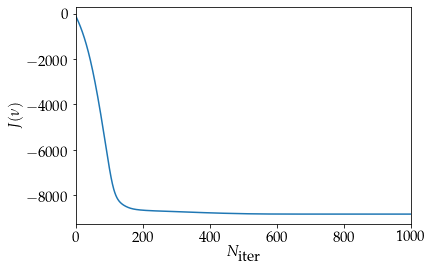

In [44]:
plt.plot(emulator.gp_module.d_opt['loss'])
plt.xlim(0, cfg.emu.niter)
plt.ylabel(r'$J(\nu)$', fontsize = fontSize)
plt.xlabel(r'$N_{\textrm{iter}}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

## Accuracy

In [45]:
%%time
gp_predictions = np.array(list(map(emulator.prediction, samples[0:NTEST])))

CPU times: user 388 ms, sys: 233 ms, total: 621 ms
Wall time: 204 ms


In [46]:
%%time
camb_predictions = calculate_loglike(samples[0:NTEST])

CPU times: user 1h 41min 41s, sys: 4min 13s, total: 1h 45min 54s
Wall time: 13min 22s


Planck

In [47]:
%%time
gp_predictions_planck = np.array(list(map(emulator.prediction, cosmoparams[0:NTEST])))

CPU times: user 316 ms, sys: 444 ms, total: 760 ms
Wall time: 208 ms


In [48]:
%%time
camb_predictions_planck = calculate_loglike(cosmoparams[0:NTEST])

CPU times: user 1h 50min 4s, sys: 4min 15s, total: 1h 54min 19s
Wall time: 15min 55s


In [49]:
fraction = (gp_predictions - camb_predictions)/camb_predictions
fraction_planck = (gp_predictions_planck - camb_predictions_planck)/camb_predictions_planck

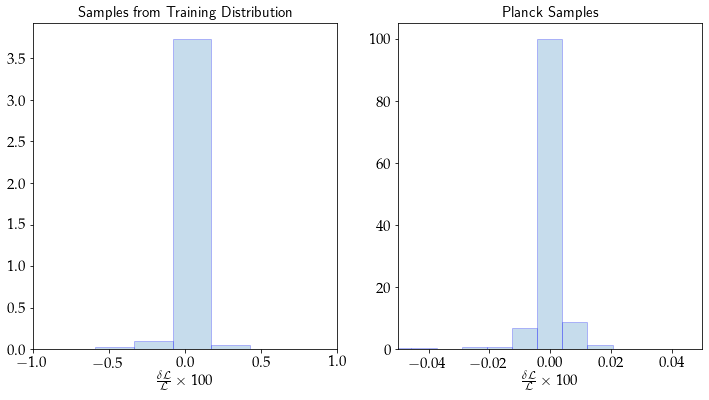

In [77]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Samples from Training Distribution', fontsize = fontSize)
plt.hist(fraction*100, density=True, bins = 20, edgecolor = 'b', alpha = 0.25)
plt.xlabel(r'$\frac{\delta\mathcal{L}}{\mathcal{L}} \times 100$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(-1.0, 1.0)
plt.subplot(122)
plt.title('Planck Samples', fontsize = fontSize)
plt.hist(fraction_planck*100, density=True, bins = 20, edgecolor = 'b', alpha = 0.25)
plt.xlabel(r'$\frac{\delta\mathcal{L}}{\mathcal{L}} \times 100$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(-0.05, 0.05)
plt.show()

# Optimisation

In [51]:
# params = torch.from_numpy(mean) + 1E-3 * torch.randn(5)
# lrate = 1E-3
# niter = 500

# # make sure we are differentiating with respect to the parameters
# params.requires_grad = True

# # initialise the optimiser
# optimiser = torch.optim.Adam([params], lr=lrate)

# loss = emulator.gp_module.prediction(params)

# # an empty list to store the loss
# record_loss = [loss.item()]

# # run the optimisation
# for _ in range(niter):
#     optimiser.zero_grad()
#     loss.backward()
#     optimiser.step()

#     # evaluate the loss
#     loss = emulator.gp_module.prediction(params)

#     # record the loss at every step
#     record_loss.append(loss.item())

# 1D Distribution

In [52]:
def generate_pdf_camb(cfg, paramname, fiducial, npoints = 25, returnemu: bool = False):

    if paramname == 'ombh2':
        grid = np.linspace(0.015, 0.030, npoints)
        
    if paramname == 'omch2':
        grid = np.linspace(0.10, 0.15, npoints)
        
    if paramname == 'thetastar':
        grid = np.linspace(1.02, 1.06, npoints)
        
    if paramname == 'ns':
        grid = np.linspace(0.90, 1.05, npoints)
        
    if paramname == 'tau':
        grid = np.linspace(0.01, 0.10, npoints)
        
    if paramname == 'As':
        grid = np.linspace(2.95, 3.15, npoints)
    
    idx = cfg.cosmo.names.index(paramname)  
    points = np.tile(fiducial, (npoints,1))
    points[:,idx] = grid
    camb_pred = calculate_loglike(points)
    if returnemu:
        gp_pred = np.array(list(map(emulator.prediction, points)))
        return grid, camb_pred, gp_pred
    return grid, camb_pred      

In [233]:
# peakvalue = np.array([0.021851289403580783,
#  0.12134623401874374,
#  1.0414217039828337,
#  0.06139950550272463,
#  3.044965394612245,
#  0.95381224402205])

# ombh2 : -594.18
# omch2 : -590.59
# thetastar : -602.08
# tau : -586.56
# As : -587.43
# ns : -599.40
    
peakvalue = mean

# ombh2 : -604.38
# omch2 : -613.42
# thetastar : -613.21
# tau : -605.16
# As : -607.61
# ns : -606.77

In [234]:
record = {}
for name in cfg.cosmo.names:
    grid, camb_pred = generate_pdf_camb(cfg, name, peakvalue, npoints = 25, returnemu = False)
    record[name] = {'grid': grid, 'camb': camb_pred}

In [235]:
# pdf_gp = np.exp(gp_pred - max(gp_pred))
# pdf_camb = np.exp(camb_pred - max(camb_pred))

ombh2 : -581.31, 0.021250
omch2 : -581.59, 0.122917
thetastar : -585.15, 1.040000
tau : -580.37, 0.047500
As : -581.12, 3.025000
ns : -580.46, 0.950000


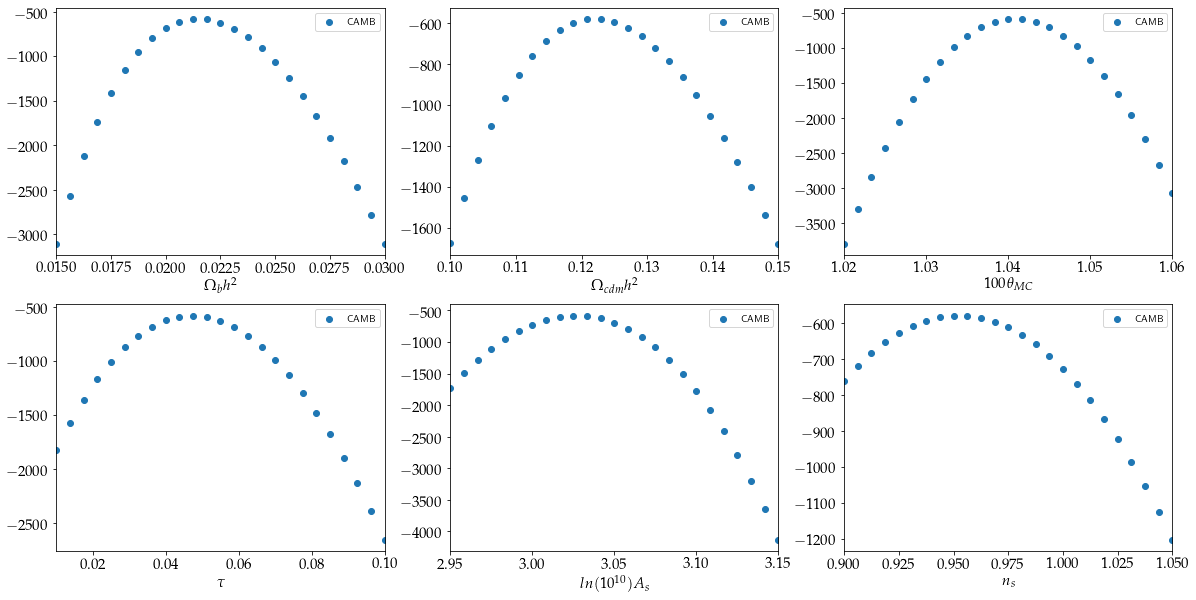

In [245]:
plt.figure(figsize = (20,10))
for i, name in enumerate(cfg.cosmo.names):
    print(f'{name} : {max(record[name]["camb"]):.2f}, {record[name]["grid"][np.argmax(record[name]["camb"])].item():2f}')
    plt.subplot(2, math.ceil(NDIM/2), i+1)
    # plt.scatter(record[name]['grid'], record[name]['gp'], label = 'Emulator')
    plt.scatter(record[name]['grid'], record[name]['camb'], label = 'CAMB')
    plt.xlim(min(record[name]['grid']), max(record[name]['grid']))
    plt.xlabel(labels[i], fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
    plt.legend()
plt.show()

# Sampling

In [57]:
def emcee_logprior_uniform(parameters):
    logp = 0.0 
    for i, p in enumerate(priors):
        logp += priors[p].logpdf(parameters[i])
    return logp

def emcee_logprior_multivariate(parameters):
    logp = priors.logpdf(parameters)
    return logp

def emcee_loglike(parameters):
    if USE_GP:
        loglike = emulator.prediction(parameters)
    else:
        loglike = calculate_loglike(parameters.reshape(1, -1))
    return loglike

In [58]:
def emcee_logpost(parameters):
    loglike = emcee_loglike(parameters)
    if UNIFORM_PRIOR:
        logprior = emcee_logprior_uniform(parameters)
    else:
        logprior = emcee_logprior_multivariate(parameters)
    
    # we need the point to lie within the prior for emulation
    # this is because we are doing a zero mean GP.
#     prior_value = np.exp(logprior)
#     if prior_value < 1E-5 or not np.isfinite(prior_value):
#         return -1E32
    logpost = loglike + logprior
    if np.isfinite(logpost):
        return logpost
    return -1E32

In [59]:
factor = 1E-4
nsamples_mcmc = 10000
pos = peakvalue + factor * np.random.normal(size = (2*NDIM, NDIM))
nwalkers = pos.shape[0]

In [60]:
sampler = emcee.EnsembleSampler(nwalkers, NDIM, emcee_logpost)
sampler.run_mcmc(pos, nsamples_mcmc, progress=True);

100%|██████████| 10000/10000 [00:32<00:00, 309.96it/s]


In [61]:
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)
flat_prob = sampler.get_log_prob(discard=1000, thin=15, flat=True)

In [62]:
maxpoint = flat_samples[np.argmax(flat_prob)]
minpoint = flat_samples[np.argmin(flat_prob)]

In [63]:
emulator.prediction(maxpoint)

-578.2139816277389

In [64]:
emulator.prediction(minpoint)

-587.7926831102458

In [72]:
calculate_loglike(mean.reshape(1,-1))

array([-614.42447087])

In [65]:
calculate_loglike(maxpoint.reshape(1, -1))

array([-579.65689829])

In [66]:
calculate_loglike(minpoint.reshape(1, -1))

array([-586.13324581])

In [67]:
for i in range(100):
    emu_like = emulator.prediction(flat_samples[i])
    sim_like = calculate_loglike(flat_samples[i].reshape(1, -1)).item()
    print(f'Simulator log-likelihood: {sim_like:.3f}')
    print(f'Emulator log-likelihood : {emu_like:.3f}')
    print(f'Difference in log-L     : {sim_like - emu_like:.3f}')
    print('-'*75)

Simulator log-likelihood: -582.335
Emulator log-likelihood : -582.202
Difference in log-L     : -0.133
---------------------------------------------------------------------------
Simulator log-likelihood: -586.241
Emulator log-likelihood : -583.737
Difference in log-L     : -2.504
---------------------------------------------------------------------------
Simulator log-likelihood: -581.450
Emulator log-likelihood : -580.209
Difference in log-L     : -1.241
---------------------------------------------------------------------------
Simulator log-likelihood: -579.574
Emulator log-likelihood : -578.553
Difference in log-L     : -1.022
---------------------------------------------------------------------------
Simulator log-likelihood: -583.895
Emulator log-likelihood : -583.338
Difference in log-L     : -0.556
---------------------------------------------------------------------------
Simulator log-likelihood: -581.351
Emulator log-likelihood : -581.133
Difference in log-L     : -0.219
--

Simulator log-likelihood: -579.257
Emulator log-likelihood : -577.716
Difference in log-L     : -1.541
---------------------------------------------------------------------------
Simulator log-likelihood: -580.823
Emulator log-likelihood : -579.346
Difference in log-L     : -1.477
---------------------------------------------------------------------------
Simulator log-likelihood: -586.540
Emulator log-likelihood : -585.802
Difference in log-L     : -0.738
---------------------------------------------------------------------------
Simulator log-likelihood: -582.117
Emulator log-likelihood : -580.324
Difference in log-L     : -1.792
---------------------------------------------------------------------------
Simulator log-likelihood: -581.485
Emulator log-likelihood : -580.000
Difference in log-L     : -1.486
---------------------------------------------------------------------------
Simulator log-likelihood: -581.325
Emulator log-likelihood : -580.739
Difference in log-L     : -0.585
--

Simulator log-likelihood: -580.227
Emulator log-likelihood : -580.086
Difference in log-L     : -0.141
---------------------------------------------------------------------------
Simulator log-likelihood: -581.165
Emulator log-likelihood : -579.390
Difference in log-L     : -1.775
---------------------------------------------------------------------------
Simulator log-likelihood: -580.397
Emulator log-likelihood : -579.416
Difference in log-L     : -0.981
---------------------------------------------------------------------------
Simulator log-likelihood: -581.100
Emulator log-likelihood : -579.931
Difference in log-L     : -1.169
---------------------------------------------------------------------------
Simulator log-likelihood: -581.199
Emulator log-likelihood : -580.132
Difference in log-L     : -1.067
---------------------------------------------------------------------------
Simulator log-likelihood: -581.373
Emulator log-likelihood : -580.974
Difference in log-L     : -0.399
--

In [68]:
samples_3 = MCSamples(samples=flat_samples,names = names, labels = labels, settings = settings, label = 'Likelihood Emulator')

Removed no burn in


In [142]:
camb_samples_1 = np.loadtxt('samples/camb_samples_1.txt')
camb_samples_2 = np.loadtxt('samples/camb_samples_2.txt')

In [284]:
samples_gp = pickle_load('samples', 'samples_GP_multivariate_2500_1')

In [285]:
samples_gp_thin = samples_gp.get_chain(discard=100, thin=2, flat=True)

In [288]:
samples_4 = MCSamples(samples=camb_samples_1,names = names, labels = labels, settings = settings, label = 'CAMB')
samples_5 = MCSamples(samples=samples_gp_thin,names = names, labels = labels, settings = settings, label = 'Emulator')

Removed no burn in
Removed no burn in


In [92]:
mean_chain = np.mean(flat_samples, axis = 0)
std_chain = np.std(flat_samples, axis = 0)

In [124]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [125]:
np.around(mean_chain, 3)

array([0.022, 0.122, 1.041, 0.048, 3.030, 0.955])

In [126]:
np.around(std_chain * 1000, 3)

array([0.097, 1.006, 0.236, 8.321, 17.105, 2.892])

In [127]:
np.around(mean, 3)

array([0.022, 0.120, 1.041, 0.054, 3.045, 0.965])

In [129]:
np.around(std * 1000, 3)

array([0.151, 1.386, 0.312, 7.990, 16.135, 4.420])

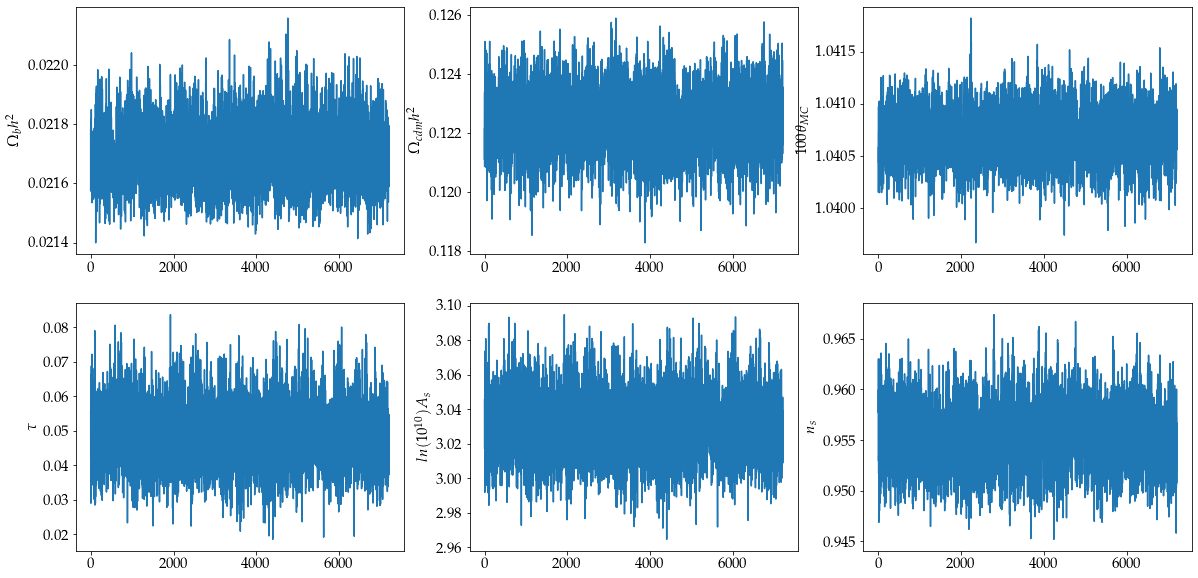

In [69]:
plt.figure(figsize = (20,10))
for i, name in enumerate(cfg.cosmo.names):
    plt.subplot(2, 3, i+1)
    plt.plot(flat_samples[:,i])
    plt.ylabel(labels[i], fontsize = fontSize)
    plt.tick_params(axis='x', labelsize=fontSize)
    plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

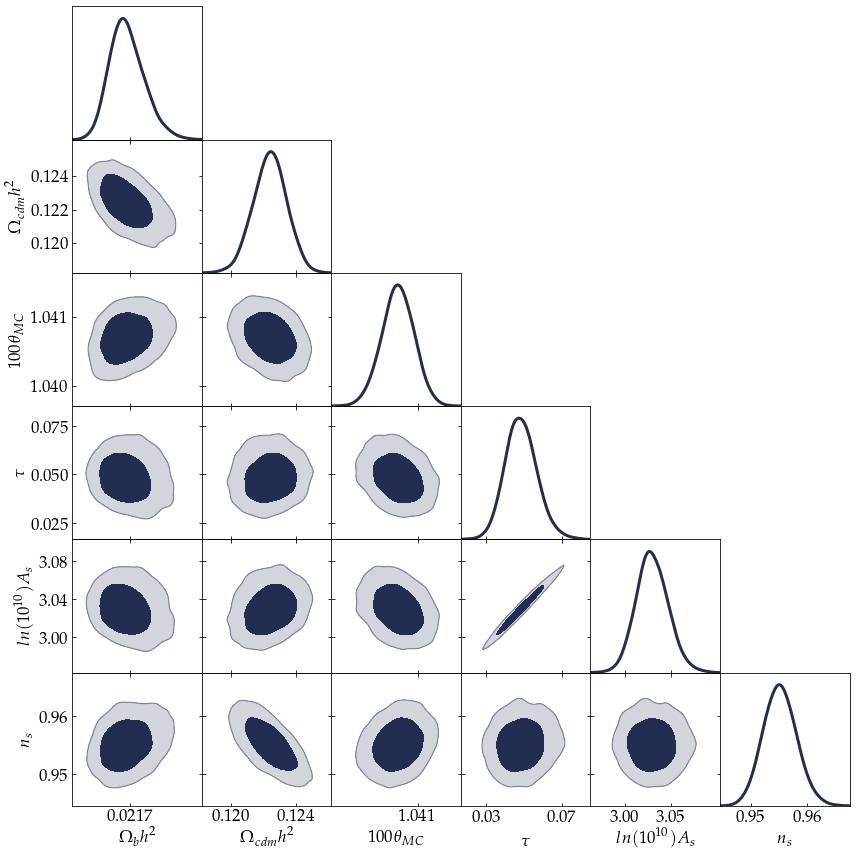

In [70]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_3.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot(samples_3, filled = True, contour_colors=[c3], contour_lws=3)
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

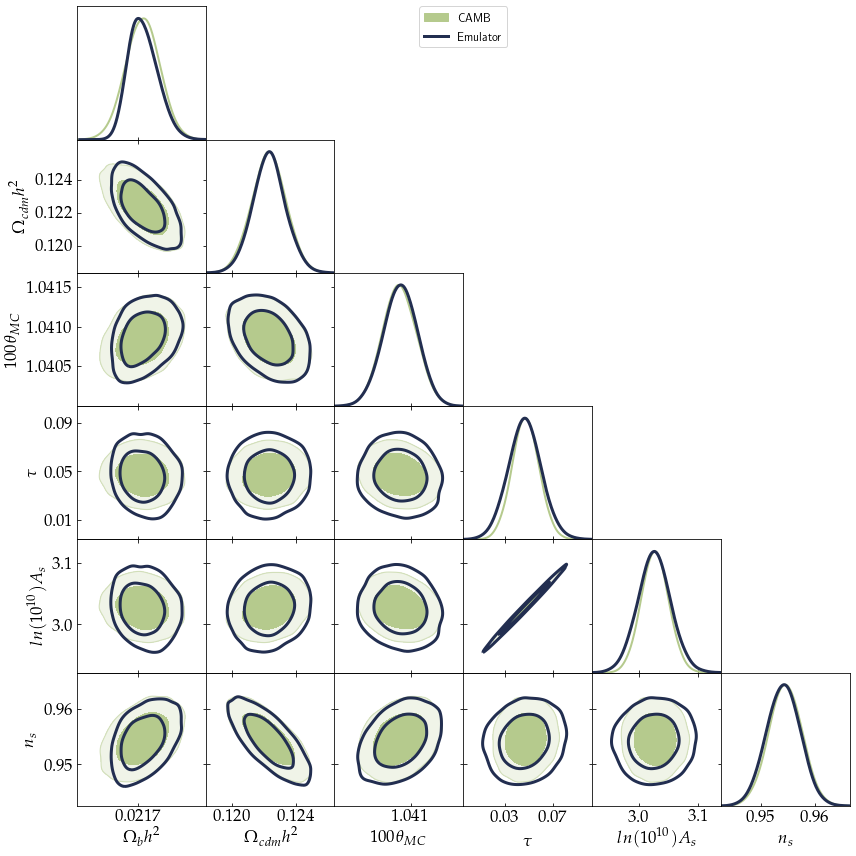

In [289]:
G = plots.getSubplotPlotter(subplot_size=2)
G.settings.solid_contour_palefactor = 0.8
G.settings.alpha_filled_add = alpha
G.settings.num_plot_contours = 2
G.settings.lw_contour = 2
G.settings.axes_fontsize = 20
G.settings.lab_fontsize = 20
G.settings.fontsize = 35 # important for padding in x-axis 
G.settings.legend_fontsize = 15
samples_1.updateSettings({'contours': [0.68, 0.95]})
samples_2.updateSettings({'contours': [0.68, 0.95]})
G.triangle_plot([samples_4, samples_5], filled = [True,False], contour_colors=[c1, c3], contour_lws=[2,3], contour_ls=['-', '-'])
# plt.savefig('plots/triangle_plot_comparison.pdf', transparent = False, bbox_inches = 'tight') 
plt.show()

In [290]:
acc_2500 = pickle_load('accuracies', 'acc_2500')

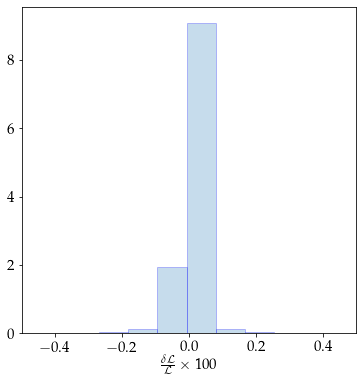

In [292]:
plt.figure(figsize=(6,6))
plt.hist(acc_2500*100, density=True, bins = 20, edgecolor = 'b', alpha = 0.25)
plt.xlabel(r'$\frac{\delta\mathcal{L}}{\mathcal{L}} \times 100$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(-0.5, 0.5)
plt.show()